In [583]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [584]:
def add_median_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y+0.03, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='black')

In [673]:

nn_files = os.listdir('results/revision/nn_results/results_deg/')

nn_results = {}

for file in nn_files:
    if file == '.DS_Store': continue
    cytokine = file.split('_')[2]
    celltype = '_'.join(file.split('_')[3:]).split('.csv')[0]
    df = pd.read_csv(f'results/revision/nn_results/results_deg/{file}', index_col = 0)  

    if cytokine not in nn_results:
        nn_results[cytokine] = {} 

    nn_results[cytokine][celltype] = df 

In [674]:
for cytokine in nn_results.keys():
    nn_results[cytokine] = pd.concat(nn_results[cytokine]).reset_index().rename(columns = {'level_0':'celltype'})

In [675]:
all_cytokines = nn_results.keys()
print(len(all_cytokines))

88


In [676]:
nn_results = pd.concat(nn_results).reset_index().rename(columns = {'level_0':'cytokine'})

In [677]:
nn_results['cytokine'] = nn_results.cytokine.str.split(' ').str[0]
nn_results['cytokine'] = nn_results['cytokine'].str.replace('41BBL', '4-1BBL')
nn_results['cytokine'] = nn_results['cytokine'].str.replace('IGF-I', 'IGF-1')

In [678]:
degs = pd.read_excel('data/immunedict/41586_2023_6816_MOESM13_ESM.xlsx', sheet_name = 2)
nondegs = degs[(degs['nDEGs_display'] == '≤10')]
nondegs['Cytokine'] = nondegs['Cytokine'].str.replace('41BBL', '4-1BBL')
nondegs['Cytokine'] = nondegs['Cytokine'].str.replace('IGF-I', 'IGF-1')
nondegs['Cytokine'] = nondegs['Cytokine'].str.replace('LT-α1/β2', 'LTA1-B2')
nondegs['Cytokine'] = nondegs['Cytokine'].str.replace('LT-α2/β1', 'LTA2-B1')

/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_3135/2528324003.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nondegs['Cytokine'] = nondegs['Cytokine'].str.replace('41BBL', '4-1BBL')
/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_3135/2528324003.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nondegs['Cytokine'] = nondegs['Cytokine'].str.replace('IGF-I', 'IGF-1')
/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_3135/2528324003.py:5: SettingWithCopyWarning: 
A value

In [762]:
# filter out signatures where not <10 DEG genes
filtered_results = nn_results.merge(nondegs[['Celltype', 'Cytokine']], left_on=['cytokine', 'celltype'], right_on = ['Cytokine', 'Celltype'], how='left', indicator=True)
nn_results = filtered_results[filtered_results['_merge'] == 'left_only'].drop(columns=['_merge'])

In [763]:
cytokine_annotation = pd.read_excel('data/immunedict/41586_2023_6816_MOESM3_ESM.xlsx')
cytokine_map = cytokine_annotation[['Cytokine', 'Mouse gene symbol']].dropna().set_index('Cytokine')['Mouse gene symbol'].to_dict()
cytokine_map['LTA1-B2'] = cytokine_map['LT-α1/β2']
cytokine_map['LTA2-B1'] = cytokine_map['LT-α2/β1']

In [764]:
nn_results['mouse_cytokine_pert'] = nn_results['cytokine'].map(cytokine_map)

In [765]:
len(nn_results['test_ligand'].unique())

1193

In [766]:
# True value table for ROC analysis
true_value_table = nn_results.copy()
true_value_table['ligand_list'] = true_value_table['test_ligand'].str.split(', ')
true_value_table = true_value_table.explode('ligand_list')
true_value_table['match'] = (true_value_table['mouse_cytokine_pert'] == true_value_table['ligand_list']).astype(int)
# we don't aggregate this by this
# true_value_table = true_value_table.pivot_table(index=['cytokine', 'celltype'], columns='ligand_list', values='match',
#                                       aggfunc='max', fill_value=0)
true_value_table = true_value_table.pivot_table(index=['cytokine', 'celltype'], columns='ligand_list', values='match', fill_value=0)
true_value_table.columns.name = None
true_value_table = true_value_table.loc[true_value_table.any(axis=1)]
true_value_table = true_value_table.loc[:, true_value_table.any(axis=0)]# - if I would like ot use only the cytokines for the analysis

In [767]:
true_value_table = true_value_table.reset_index()
true_value_table['index'] = true_value_table['cytokine'] + '_' + true_value_table['celltype']
true_value_table = true_value_table.set_index('index', drop = True)
true_value_table = true_value_table.drop(columns = ['cytokine', 'celltype'])

In [800]:
nn_results_mod = nn_results.copy() #nn_results.groupby(['mouse_cytokine_pert', 'cytokine', 'test_ligand'])[['aupr_corrected', 'pearson']].mean().reset_index()#
nn_results_mod['ligand_list'] = nn_results_mod['test_ligand'].str.split(', ')
nn_results_mod = nn_results_mod.explode('ligand_list')
nn_results_mod = nn_results_mod.drop_duplicates(subset=['cytokine', 'celltype', 'ligand_list'])
nn_results_mod = nn_results_mod.pivot(index=['cytokine', 'celltype'], columns='ligand_list', values='aupr')
nn_results_mod = nn_results_mod[list(set(nn_results_mod.columns)  & set(true_value_table.columns))]

In [801]:
nn_results_mod = nn_results_mod.reset_index()
nn_results_mod['index'] = nn_results_mod['cytokine'] + '_' + nn_results_mod['celltype']
nn_results_mod = nn_results_mod.set_index('index', drop = True)
nn_results_mod = nn_results_mod.drop(columns = ['cytokine', 'celltype'])

In [802]:
true_value_table, nn_results_mod = true_value_table.align(nn_results_mod)
print(nn_results_mod.shape, true_value_table.shape)

(698, 64) (698, 64)


In [803]:
roc_auc_results = {}
for cytokine in true_value_table.columns:
    valid_idx = nn_results_mod[cytokine].notna() & true_value_table[cytokine].notna()
    y_true = true_value_table[cytokine][valid_idx]
    y_calc = nn_results_mod[cytokine][valid_idx]

    # Compute ROC AUC only if we have both 0s and 1s after filtering
    if len(set(y_true)) > 1:
        roc_auc = roc_auc_score(y_true, y_calc)
        roc_auc_results[cytokine] = roc_auc
    else:
        roc_auc_results[cytokine] = None
nn_roc_auc_results = pd.DataFrame.from_dict(roc_auc_results, orient='index', columns=['ROC_AUC'])


In [804]:
# nn_roc_auc_results['ROC_AUC'] = 1- nn_roc_auc_results['ROC_AUC'] # if we check rank

In [805]:
nn_roc_auc_results

,ROC_AUC
Adipoq,0.546032
C3,0.814803
Cd40lg,0.349440
Cd70,0.568755
Csf1,0.296296
...,...
Tnfsf18,0.596657
Tnfsf4,0.701657
Tnfsf9,0.466535
Tslp,0.376144


In [806]:
# nn_roc_auc_results.to_csv('results/revision/nn_immunedict_rocauc_noaggregation.csv')

In [807]:
cytokines = nn_results_mod.index.str.split('_').str[0].unique()
results ={}
for cyt in cytokines:
    if cyt == 'PBS':
        continue
    if cytokine_map[cyt] not in nn_results_mod.columns:
        continue
    pert = nn_results_mod[nn_results_mod.index.str.contains(cyt)][cytokine_map[cyt]].dropna()
    notpert = nn_results_mod[~nn_results_mod.index.str.contains(cyt)][cytokine_map[cyt]].dropna()
    res = ttest_ind(pert, notpert)
    results[cyt] = {'mousegenesymbol':cytokine_map[cyt], 'tstat':res[0], 'pval':res[1]}
results = pd.DataFrame(results).T

In [808]:
results.sort_values(by = 'tstat')

,mousegenesymbol,tstat,pval
M-CSF,Csf1,-1.94199,0.053148
GM-CSF,Csf2,-1.927707,0.054569
IL-4,Il4,-1.903677,0.057364
IL-13,Il13,-1.896655,0.058287
IFN-λ2,Ifnl2,-1.661417,0.097093
...,...,...,...
PSPN,Pspn,2.073588,0.039154
C3a,C3,3.659548,0.000272
LIGHT,Tnfsf14,5.179211,0.000001
IFN-α1,Ifna1,8.206693,0.0


/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_3135/4212025952.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Cytokines'])


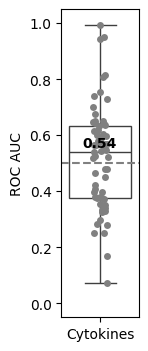

In [809]:
fig, ax = plt.subplots(figsize = (1, 4))
sns.boxplot(nn_roc_auc_results, ax =ax, color = 'white')
sns.stripplot(nn_roc_auc_results, ax =ax, color = 'gray')
plt.ylim(-0.05, 1.05)
add_median_labels(ax)
plt.axhline(0.5, linestyle = '--', color = 'gray')
ax.set_xticklabels(['Cytokines'])
plt.ylabel('ROC AUC')
# plt.savefig('figures/revision/nichnet_rocauc_noaggr.pdf', bbox_inches = 'tight', dpi = 300)
# plt.savefig('figures/revision/nichnet_rocauc_noaggr.png', bbox_inches = 'tight', dpi = 300)
# plt.savefig('figures/revision/nichnet_rocauc_noaggr.jpg', bbox_inches = 'tight', dpi = 300)
plt.show()

In [474]:
# CD30L, IL-12, IL-17B

In [38]:
# 2 options:
# I calculate the ROCAUC between all the celltypes and than aveage the rocauc
# I calcualte the RICAUC between merged max ligand activity

In [94]:
len(cytokine_map.keys())

86

In [103]:
final_immunedict = pd.read_csv('data/immunedict/mean_zscore_normed_per_cytokine_per_celltype.csv', index_col = 0)


In [181]:
rocauc_results_all_immunedict = pd.read_csv(f'figures/validation/immunedict/immunedict_lincs_rocauc_filtered.csv')

In [185]:
rocauc_results_all_immunedict[rocauc_results_all_immunedict['ConfidenceLevel'] =='RIDDEN ALL overlap']

,Unnamed: 0,ConfidenceLevel,ROC AUC
0,SMAD3,RIDDEN ALL overlap,0.960563
1,EGFR,RIDDEN ALL overlap,0.240266
2,TGFBR1,RIDDEN ALL overlap,0.969014
3,CSF1R,RIDDEN ALL overlap,0.225921
4,ERBB2,RIDDEN ALL overlap,0.224504
5,IL10RB,RIDDEN ALL overlap,0.442512
6,TGFBR3,RIDDEN ALL overlap,0.843662
7,IL1RAP,RIDDEN ALL overlap,0.678680
8,IL6ST,RIDDEN ALL overlap,0.364837
9,TGFBR2,RIDDEN ALL overlap,0.757746
